### Imports

In [120]:
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from utils.utils_go import *

import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import sys

# %load_ext autotime

### Parameters

In [121]:
file = open("exp.json")
experiment = json.load(file)
exp_num = "exp3" # experiment["exp"]

file = open("output/{}/parameters.json".format(exp_num))
params = json.load(file)

exp = params["exp"]
print("Exp:\t\t", exp)

methods = params["methods"]
print("Methods:\t", methods)

data_variations = params["data_variations"]
print("Data variations:", data_variations)

groups_id = params["groups_id"]
print("Groups id:\t", groups_id)

subgroups_id = params["subgroups_id"]
print("Subgroups id:\t", subgroups_id)

Exp:		 exp3
Methods:	 ['dgi-tran', 'argva-base', 'vgae-line', 'vgae-base']
Data variations: ['none', 'str', 'dyn']
Groups id:	 ['Nueva', 'Vieja']
Subgroups id:	 {'Nueva': ['1', '2'], 'Vieja': ['1', '2']}


### Input graph detail

In [122]:
input_detail = []

for group in tqdm(groups_id):
    for subgroup in tqdm(subgroups_id[group]):
        df_edges = pd.read_csv("output/{}/preprocessing/edges/edges_{}_{}.csv".format(exp, group, subgroup))
        G = nx.from_pandas_edgelist(df_edges, "source", "target", edge_attr="weight")
        # print("{}, {}".format(group, subgroup))
        # graph_detail(G)
        input_detail.append([group, subgroup, G.number_of_nodes(), G.number_of_edges()])

df_input_detail = pd.DataFrame(input_detail, columns=["Group", "Subgroup", "Num. nodes", "Num. Edges"])
df_input_detail

100%|██████████| 2/2 [00:00<00:00, 18.22it/s]


,Group,Subgroup,Num. nodes,Num. Edges
0,Nueva,1,177,12765
1,Nueva,2,178,15753
2,Vieja,1,177,12936
3,Vieja,2,176,15400


In [123]:
print(df_input_detail.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.1f}".format)) 


\begin{tabular}{llrr}
\toprule
Group & Subgroup & Num. nodes & Num. Edges \\
\midrule
Nueva & 1 & 177 & 12765 \\
Nueva & 2 & 178 & 15753 \\
Vieja & 1 & 177 & 12936 \\
Vieja & 2 & 176 & 15400 \\
\bottomrule
\end{tabular}



### Results

In [124]:
results = []

for group in groups_id:
    df_common_edges = pd.read_csv("output/{}/common_edges/common_edges_{}_{}_{}.csv".format(exp, "greedy", group, "none"))
    G = nx.from_pandas_edgelist(df_common_edges, edge_attr=["weight"])
    results.append(["greedy", group, "none", G.number_of_nodes(), G.number_of_edges()])
    
for method in methods:
    for group in groups_id:
        for data_variation in data_variations:
            df_common_edges = pd.read_csv("output/{}/common_edges/common_edges_{}_{}_{}.csv".format(exp, method, group, data_variation))
            G = nx.from_pandas_edgelist(df_common_edges, edge_attr=["weight"])
            results.append([method, group, data_variation, G.number_of_nodes(), G.number_of_edges()])

df_results = pd.DataFrame(results, columns=["Method", "Group", "Data var.", "Num. nodes", "Num. edges"])
# df_results.to_csv("output/{}/common_edges/details.csv".format(exp), index=False)
# df_results.replace("greedy", "baseline", inplace=True)
df_results

,Method,Group,Data var.,Num. nodes,Num. edges
0,greedy,Nueva,none,177,9240
1,greedy,Vieja,none,176,8660
2,dgi-tran,Nueva,none,177,7212
3,dgi-tran,Nueva,str,177,7224
4,dgi-tran,Nueva,dyn,177,7561
5,dgi-tran,Vieja,none,176,6840
6,dgi-tran,Vieja,str,176,6849
7,dgi-tran,Vieja,dyn,176,6952
8,argva-base,Nueva,none,177,7481
9,argva-base,Nueva,str,177,7448


In [125]:
max_nodes = df_results.iloc[:3, :]["Num. nodes"].to_list()
max_nodes

max_edges = df_results.iloc[:3, :]["Num. edges"].to_list()
max_edges

[9240, 8660, 7212]

In [126]:
""" new_cmap = plt.get_cmap("tab10", 8)
colors = [matplotlib.colors.to_hex(new_cmap(i)) for i in range(8)]
colors """

' new_cmap = plt.get_cmap("tab10", 8)\ncolors = [matplotlib.colors.to_hex(new_cmap(i)) for i in range(8)]\ncolors '

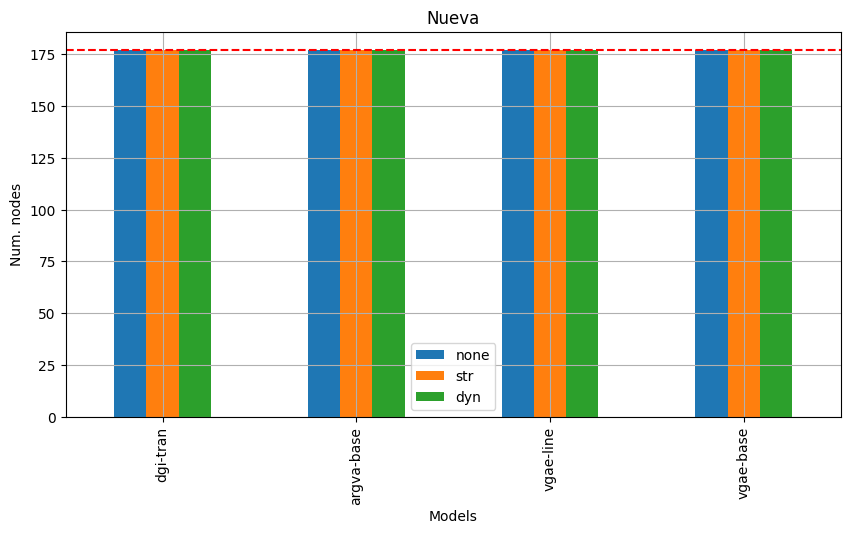

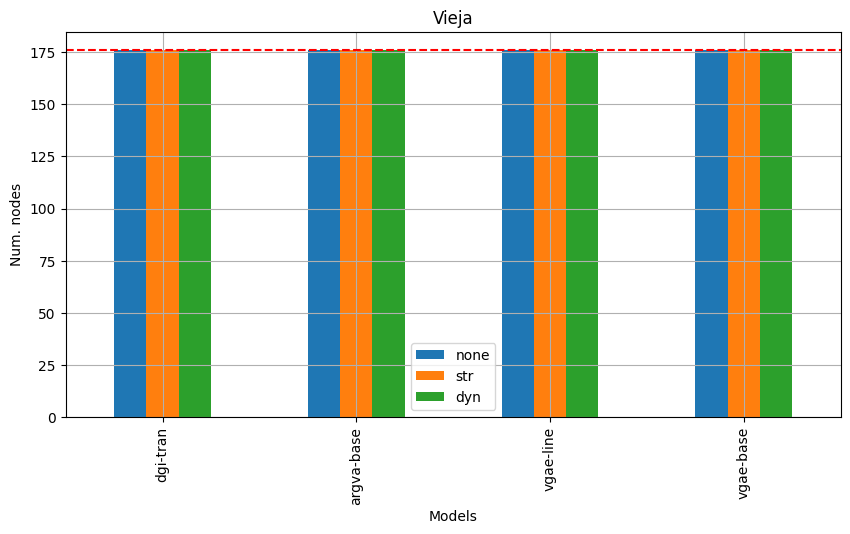

In [127]:
# plot bar nodes
df_temp = df_results.iloc[len(groups_id):, :]

for i, group_id in enumerate(groups_id):
    data = {}
    # max_values = []
    for data_variation in data_variations:
        df_aux = df_temp[df_temp["Group"] == group_id]
        df_aux = df_aux[df_aux["Data var."] == data_variation]
        data[data_variation] = df_aux["Num. nodes"].to_list()
        # max_values.append(max(df_aux["Num. nodes"].to_list()))
    
    plotdata = pd.DataFrame(data, index=methods)
    plotdata.plot(kind="bar", figsize=(10, 5))
    plt.title(group_id)
    plt.xlabel("Models")
    plt.ylabel("Num. nodes")
    """ for i, max_ in enumerate(max_nodes):
        plt.axhline(y=max_, color=colors[i], linestyle="--") """
    plt.axhline(y=max_nodes[i], color="red", linestyle="--")
    plt.grid()

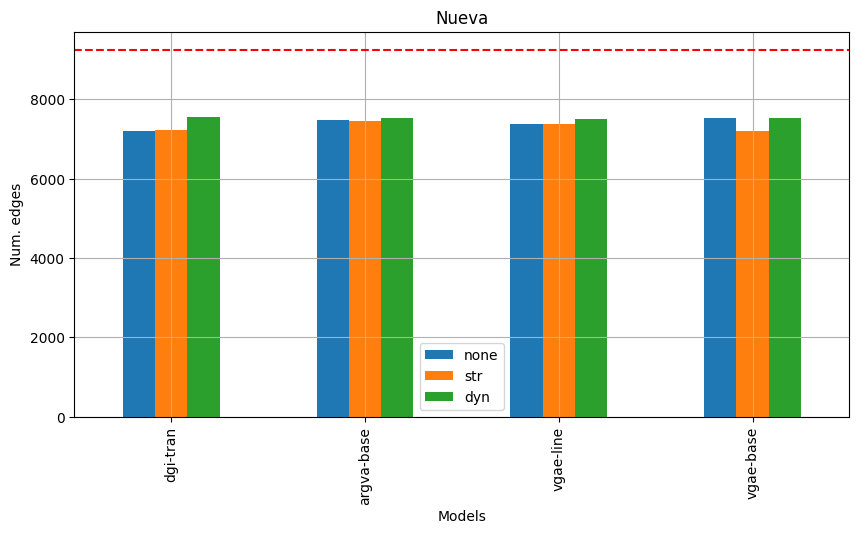

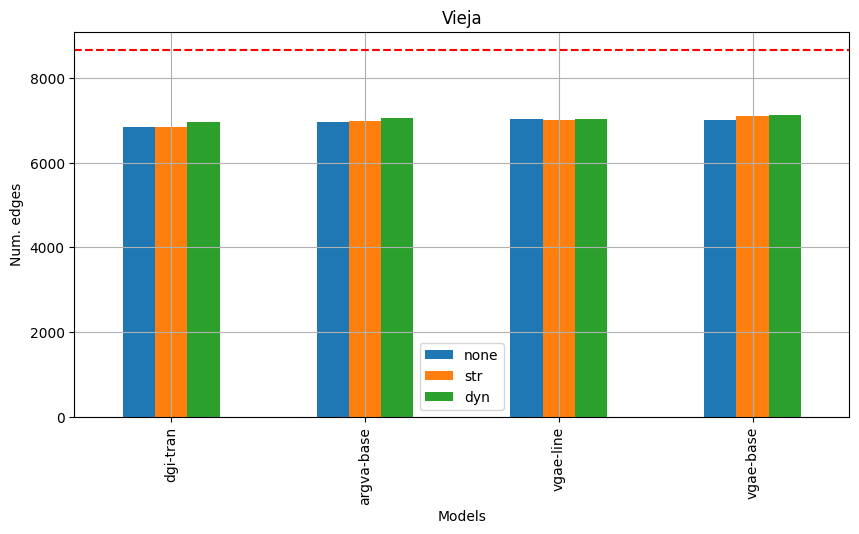

In [128]:
# plot bar edges

df_temp = df_results.iloc[len(groups_id):, :]

for i, group_id in enumerate(groups_id):
    data = {}
    # max_values = []
    for data_variation in data_variations:
        df_aux = df_temp[df_temp["Group"] == group_id]
        df_aux = df_aux[df_aux["Data var."] == data_variation]
        data[data_variation] = df_aux["Num. edges"].to_list()
        # max_values.append(max(df_aux["Num. edges"].to_list()))
    
    plotdata = pd.DataFrame(data, index=methods)
    plotdata.plot(kind="bar", figsize=(10, 5))
    plt.title(group_id)
    plt.xlabel("Models")
    plt.ylabel("Num. edges")
    """ for i, max_ in enumerate(max_nodes):
        plt.axhline(y=max_, color=colors[i], linestyle="--") """
    plt.axhline(y=max_edges[i], color="red", linestyle="--")
    plt.grid()

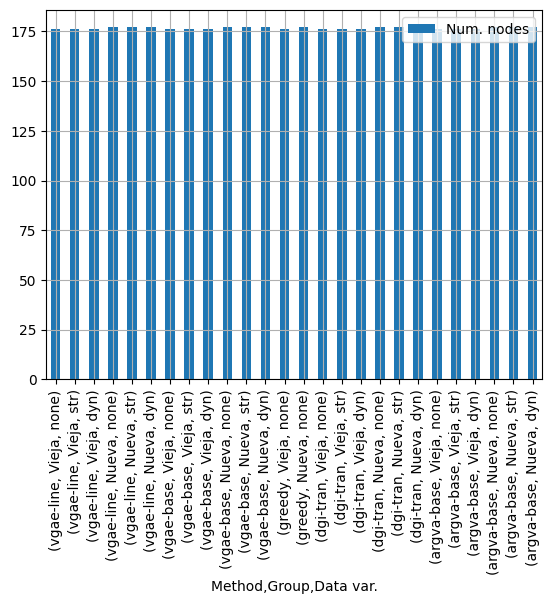

In [129]:
df_results_temp = df_results.iloc[:, [0, 1, 2, 3]].set_index(["Method", "Group", "Data var."])
df_results_temp.sort_values(by=["Method", "Group", "Num. nodes"], ascending=False, inplace=True)
ax = df_results_temp.plot.bar(rot=90)
ax.grid()

# plt.xticks(rotation=90)
# ax.set_xticklabels(df_results["Method", "Group", "Option"], rotation=90, ha='right')

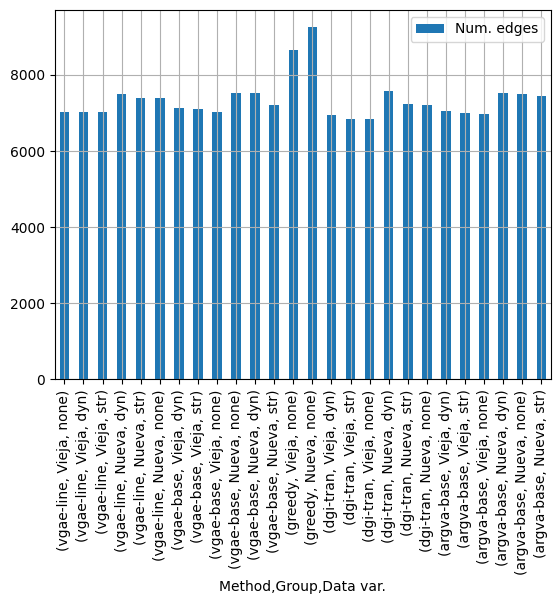

In [130]:
df_results_temp = df_results.iloc[:, [0, 1, 2, 4]].set_index(["Method", "Group", "Data var."])
df_results_temp.sort_values(by=["Method", "Group", "Num. edges"], ascending=False, inplace=True)
ax = df_results_temp.plot.bar(rot=90)
ax.grid()

In [131]:
total = []
nodes = []
edges = []

for i in tqdm(df_results.index[:len(groups_id)]):
    total.append([df_results["Num. nodes"][i], df_results["Num. edges"][i]])
    nodes.append("{} ({}%)".format(df_results["Num. nodes"][i], round(df_results["Num. nodes"][i]*100/df_results["Num. nodes"][i], 2)))
    edges.append("{} ({}%)".format(df_results["Num. edges"][i], round(df_results["Num. edges"][i]*100/df_results["Num. edges"][i], 2)))

index = 0
c = 0
for i in tqdm(df_results.index[len(groups_id):]):
    nodes.append("{} ({}%)".format(df_results["Num. nodes"][i], round(df_results["Num. nodes"][i]*100/total[index][0], 2)))
    edges.append("{} ({}%)".format(df_results["Num. edges"][i], round(df_results["Num. edges"][i]*100/total[index][1], 2)))

    c += 1
    if c % len(data_variations) == 0:
        index = (index + 1) % len(groups_id)

100%|██████████| 24/24 [00:00<00:00, 48349.33it/s]


In [132]:
df_results_ = df_results.copy()
df_results_["Num. nodes"] = nodes
df_results_["Num. edges"] = edges
df_results_.to_csv("output/{}/common_edges/details.csv".format(exp), index=False)
df_results_.head(50)

,Method,Group,Data var.,Num. nodes,Num. edges
0,greedy,Nueva,none,177 (100.0%),9240 (100.0%)
1,greedy,Vieja,none,176 (100.0%),8660 (100.0%)
2,dgi-tran,Nueva,none,177 (100.0%),7212 (78.05%)
3,dgi-tran,Nueva,str,177 (100.0%),7224 (78.18%)
4,dgi-tran,Nueva,dyn,177 (100.0%),7561 (81.83%)
5,dgi-tran,Vieja,none,176 (100.0%),6840 (78.98%)
6,dgi-tran,Vieja,str,176 (100.0%),6849 (79.09%)
7,dgi-tran,Vieja,dyn,176 (100.0%),6952 (80.28%)
8,argva-base,Nueva,none,177 (100.0%),7481 (80.96%)
9,argva-base,Nueva,str,177 (100.0%),7448 (80.61%)


In [133]:
print(df_results_.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.1f}".format)) 

\begin{tabular}{lllll}
\toprule
Method & Group & Data var. & Num. nodes & Num. edges \\
\midrule
greedy & Nueva & none & 177 (100.0%) & 9240 (100.0%) \\
greedy & Vieja & none & 176 (100.0%) & 8660 (100.0%) \\
dgi-tran & Nueva & none & 177 (100.0%) & 7212 (78.05%) \\
dgi-tran & Nueva & str & 177 (100.0%) & 7224 (78.18%) \\
dgi-tran & Nueva & dyn & 177 (100.0%) & 7561 (81.83%) \\
dgi-tran & Vieja & none & 176 (100.0%) & 6840 (78.98%) \\
dgi-tran & Vieja & str & 176 (100.0%) & 6849 (79.09%) \\
dgi-tran & Vieja & dyn & 176 (100.0%) & 6952 (80.28%) \\
argva-base & Nueva & none & 177 (100.0%) & 7481 (80.96%) \\
argva-base & Nueva & str & 177 (100.0%) & 7448 (80.61%) \\
argva-base & Nueva & dyn & 177 (100.0%) & 7530 (81.49%) \\
argva-base & Vieja & none & 176 (100.0%) & 6973 (80.52%) \\
argva-base & Vieja & str & 176 (100.0%) & 6991 (80.73%) \\
argva-base & Vieja & dyn & 176 (100.0%) & 7054 (81.45%) \\
vgae-line & Nueva & none & 177 (100.0%) & 7384 (79.91%) \\
vgae-line & Nueva & str & 177 (1